# Calculate dynamic height from CTD profiles

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyresample import geometry, kd_tree
import os
from matplotlib.lines import Line2D

Open satellite data

In [5]:
ssh_1993 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1993.nc')
ssh_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [7]:
ssh_1993_day = ssh_1993.sla.sel(time='1993-06-21') # midpoint in CTD profile sampling period

In [9]:
ssh_2024_day = ssh_2024.sla.sel(time='2024-06-12') # midpoint in CTD profile sampling period

Open CTD data

In [12]:
# open ctd data from WOCE line AR7W from 1993
ar7w_1993_ds = xr.open_dataset('/Users/mzahn/data/Labrador_AR7W/cchdo_AR07W/3_18HU93019_1_ctd.nc')

In [14]:
# open all WOD ctd data
wod_ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/WOD_2024/ocldb1770245762.3504832.CTD/ocldb1770245762.3504832.CTD.nc')

In [16]:
# select only profiles from 2024
wod_ctd_2024 = wod_ctd_ds.swap_dims({'casts':'time'}).sel(time='2024')

### Find location of 2024 profiles that match 1993 profile locations

In [19]:
# Match WOD CTD profiles to AR7W stations using pyresample (nearest neighbor)

# --- extract coordinates ---
ar_lats, ar_lons = ar7w_1993_ds.latitude.values, ar7w_1993_ds.longitude.values
wod_lats, wod_lons = wod_ctd_2024.lat.values, wod_ctd_2024.lon.values

# --- define swaths (scattered point geometry) ---
ar_swath  = geometry.SwathDefinition(lons=ar_lons,  lats=ar_lats)
wod_swath = geometry.SwathDefinition(lons=wod_lons, lats=wod_lats)

# --- nearest neighbor search ---
idx, dist, idx_valid, dist_valid = kd_tree.get_neighbour_info(
    source_geo_def=wod_swath,
    target_geo_def=ar_swath,
    radius_of_influence=5e4,
    neighbours=1)

# a bunch of ctds are out of range, so drop those ones (=last index of wod_ctd_ds array)
idx_valid = idx_valid[np.where(idx_valid!=len(wod_ctd_2024.time))]

wod_ar7w_2024 = wod_ctd_2024.isel(time=idx_valid)

In [21]:
wod_ar7w_2024.sortby('time').time.values

array(['2024-05-29T14:15:00.000000000', '2024-05-29T14:15:00.000000000',
       '2024-05-29T23:03:44.999999488', '2024-05-30T09:56:15.000000512',
       '2024-05-31T00:56:15.000000512', '2024-05-31T13:18:44.999999488',
       '2024-05-31T23:48:44.999999488', '2024-06-01T09:22:30.000000000',
       '2024-06-01T19:41:15.000000512', '2024-06-02T04:41:15.000000512',
       '2024-06-02T14:03:44.999999488', '2024-06-02T22:07:30.000000000',
       '2024-06-03T09:33:44.999999488', '2024-06-04T00:45:00.000000000',
       '2024-06-04T07:52:30.000000000', '2024-06-07T17:26:15.000000512',
       '2024-06-08T01:18:44.999999488', '2024-06-08T09:11:15.000000512',
       '2024-06-08T14:48:44.999999488', '2024-06-08T18:56:15.000000512',
       '2024-06-08T21:45:00.000000000', '2024-06-09T00:45:00.000000000',
       '2024-06-09T13:30:00.000000000', '2024-06-09T16:07:30.000000000',
       '2024-06-09T18:22:30.000000000', '2024-10-26T17:26:15.000000512',
       '2024-11-07T15:56:15.000000512'], dtype='dat

### updated version

In [24]:
import glob, os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gsw
from scipy.interpolate import interp1d

wod_ctd_dir = '/Users/mzahn/data/Labrador_AR7W/WOD_2024/ocldb1770245762.3504832.CTD'
file_list = glob.glob(f'{wod_ctd_dir}/*.nc')

# Standard pressure grid (dbar)
p_grid = np.arange(5, 3825, 5)  # from 5 to 3820 dbar, step 5

# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []
temperature_profiles = []
salinity_profiles = []

# Loop over casts in dataset
for i in range(len(wod_ar7w_2024.time)):
    wod_id = wod_ar7w_2024.isel(time=i).cast.values

    # Find the corresponding file
    matched_files = [f for f in file_list if str(wod_id) in os.path.basename(f)]
    if not matched_files:
        print(f"No file found for cast {wod_id}")
        continue

    ctd_file = matched_files[0]
    ds = xr.open_dataset(ctd_file)

    # Extract variables
    z = ds['z'].values * -1  # positive depth
    T = ds['Temperature'].where(ds.Temperature_WODflag == 0).values
    S = ds['Salinity'].where(ds.Salinity_WODflag == 0).values
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Convert to pressure and absolute/Conservative temperature
    P = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)

    # Calculate dynamic height referenced to 2000 dbar
    P_ref = 2000
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref)

    # Interpolate profiles to standard pressure grid
    interp_T = np.full_like(p_grid, np.nan, dtype=float)
    interp_S = np.full_like(p_grid, np.nan, dtype=float)
    
    valid_mask = ~np.isnan(CT) & ~np.isnan(SA)
    if np.any(valid_mask):
        f_T = interp1d(P[valid_mask], T[valid_mask], bounds_error=False, fill_value=np.nan)
        f_S = interp1d(P[valid_mask], S[valid_mask], bounds_error=False, fill_value=np.nan)
        interp_T[:] = f_T(p_grid)
        interp_S[:] = f_S(p_grid)

    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)
    temperature_profiles.append(interp_T)
    salinity_profiles.append(interp_S)

# Convert to xarray DataArrays
dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"}
)

temperature_da = xr.DataArray(
    np.array(temperature_profiles),
    dims=["cast", "pressure"],
    coords={"cast": np.arange(len(temperature_profiles)),
            "pressure": p_grid},
    name="temperature",
    attrs={"units": "°C", "long_name": "Temperature profile"}
)

salinity_da = xr.DataArray(
    np.array(salinity_profiles),
    dims=["cast", "pressure"],
    coords={"cast": np.arange(len(salinity_profiles)),
            "pressure": p_grid},
    name="salinity",
    attrs={"units": "psu", "long_name": "Salinity profile"}
)

# Combine into one dataset
final_ds = xr.Dataset({
    "dynamic_height": dynH_da,
    "temperature": temperature_da,
    "salinity": salinity_da
})

print(final_ds)

<xarray.Dataset> Size: 337kB
Dimensions:         (cast: 27, pressure: 764)
Coordinates:
  * cast            (cast) int64 216B 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26
    lat             (cast) float32 108B 53.77 53.68 53.8 ... 59.99 60.17 60.29
    lon             (cast) float32 108B -55.6 -55.54 -55.43 ... -48.69 -48.54
  * pressure        (pressure) int64 6kB 5 10 15 20 25 ... 3805 3810 3815 3820
Data variables:
    dynamic_height  (cast) float64 216B nan nan nan nan ... 9.625 10.03 10.27
    temperature     (cast, pressure) float64 165kB 2.316 2.292 2.269 ... nan nan
    salinity        (cast, pressure) float64 165kB 32.2 32.21 32.21 ... nan nan


(3800.0, 0.0)

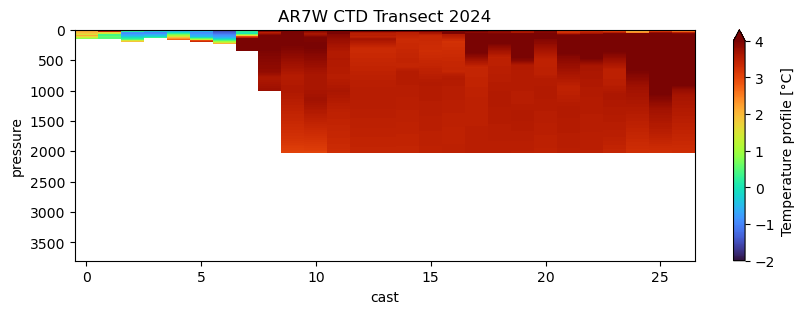

In [26]:
plt.figure(figsize=(10, 3))
final_ds.temperature.plot(
    x="cast",
    y="pressure",
    vmin=-2,
    vmax=4,
    cmap="turbo",
    add_colorbar=True
)
plt.title('AR7W CTD Transect 2024')
# plt.xlabel('Distance from coast (km)')
plt.ylim(3800, 0)
# plt.xlim(150,1100);

### Plot

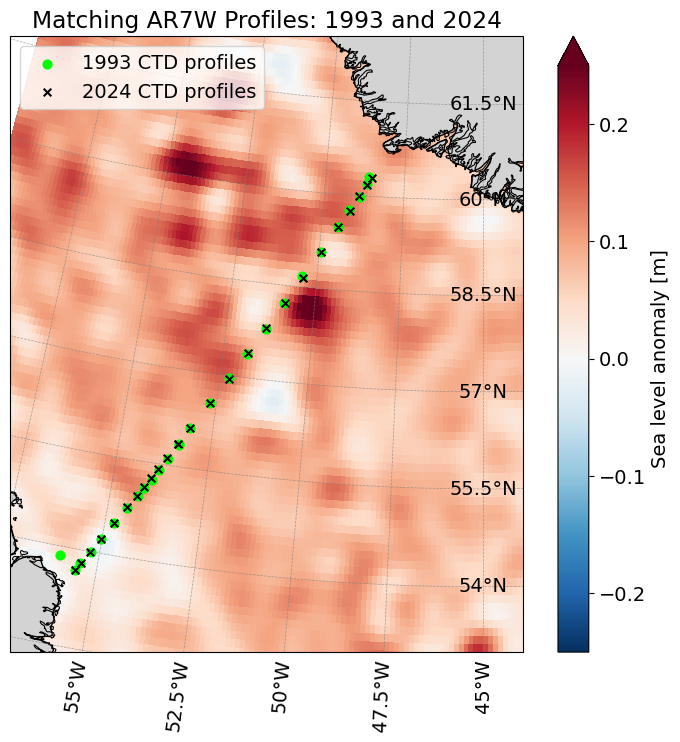

In [28]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-57, -44, 53, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='lime',
    s=40,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# Plot points for 2024
ax.scatter(
    wod_ar7w_2024.lon.values[1:],
    wod_ar7w_2024.lat.values[1:],
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles: 1993 and 2024")
plt.legend(loc='upper left')
plt.show()

## Calculate dynamic height for 1993

3558.0
3583.0
3588.0
3601.0
3561.0
3515.0
3424.0
3236.0
3041.0
2877.0
2795.0


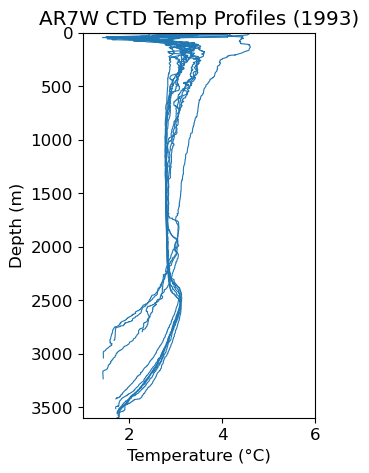

In [131]:
# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []
time_list = []

# configure plot for profiles
fig, ax = plt.subplots(figsize=(3, 5))

# Loop over casts in dataset
for i in range(len(ar7w_1993_ds.N_PROF)):
    
    # select profile
    ds_1993 = ar7w_1993_ds.isel(N_PROF=i)

    # Extract vars
    P = ds_1993['pressure'].values
    T = ds_1993['ctd_temperature'].values
    S = ds_1993['ctd_salinity'].values 
    lat = ds_1993['latitude'].values
    lon = ds_1993['longitude'].values
    time = ds_1993['time'].values

    # Convert
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)

    # identify bottom depth
    bottom_depth = ds_1993['pressure'].where(~ds_1993['pressure'].isnull(), drop=True).values[-1]
    # print(bottom_depth)
    # P_ref = bottom_depth
    P_ref = 2000
    # Calculate dynamic height referenced to the bottom
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)
    time_list.append(time)

# plot params
# plot profiles
ds_select = ar7w_1993_ds.isel(N_PROF=slice(-11, None))
for i in range(len(ds_select.N_PROF)):
    tmp = ds_select.isel(N_PROF=i)
    bottom_d = tmp['pressure'].where(~tmp['pressure'].isnull(), drop=True).values[-1]
    # print("+++++++++++++++")
    print(bottom_d)

ds_select.ctd_temperature.plot(y='pressure',hue='N_PROF',color='tab:blue',linewidth=0.8,ax=ax,add_legend=False)
ax.set_xlim(1, 6)
ax.set_ylim(3600, 0)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.set_title("AR7W CTD Temp Profiles (1993)")
plt.show()

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "time": ("cast", np.array(time_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

In [32]:
ar7w_1993_ds.isel(N_PROF=slice(-11, None)).btm_depth.values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [133]:
# convert to meters by dividing by gravity
dyn_height_1993 = dynH_da / 9.81

In [135]:
dyn_height_1993

<xarray.DataArray 'dynamic_height' (cast: 27)> Size: 216B
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.82960175,
       0.8229917 , 0.86009154, 0.87138939, 0.87239386, 0.81579904,
       0.78542906, 0.78849315, 0.80466331, 0.80407747, 0.80204853,
       0.8076584 , 0.82709918, 0.80902877, 0.81966848, 0.80690958,
       0.81099653, 0.85296283])
Coordinates:
  * cast     (cast) int64 216B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25 26
    time     (cast) datetime64[ns] 216B 1993-06-19T13:08:00 ... 1993-06-23T20...
    lat      (cast) float64 216B 53.86 53.68 53.79 53.99 ... 59.97 60.18 60.3
    lon      (cast) float64 216B -55.99 -55.54 -55.44 ... -48.89 -48.68 -48.62

In [38]:
dyn_height_1993_select = dyn_height_1993.isel(cast=slice(-11, None))

In [52]:
dyn_height_1993_select

<xarray.DataArray 'dynamic_height' (cast: 11)> Size: 88B
array([0.78849315, 0.80466331, 0.80407747, 0.80204853, 0.8076584 ,
       0.82709918, 0.80902877, 0.81966848, 0.80690958, 0.81099653,
       0.85296283])
Coordinates:
  * cast     (cast) int64 88B 16 17 18 19 20 21 22 23 24 25 26
    lat      (cast) float64 88B 56.96 57.37 57.78 58.22 ... 59.97 60.18 60.3
    lon      (cast) float64 88B -52.23 -51.8 -51.36 ... -48.89 -48.68 -48.62

## Calculate dynamic height for 2024

https://www.teos-10.org/pubs/gsw/html/gsw_geo_strf_dyn_height.html

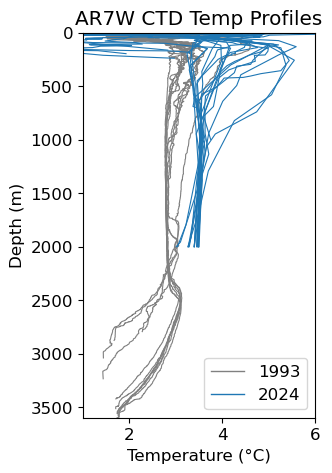

In [117]:
wod_ctd_dir = '/Users/mzahn/data/Labrador_AR7W/WOD_2024/ocldb1770245762.3504832.CTD'
file_list = glob.glob(f'{wod_ctd_dir}/*.nc')

# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []
time_list = []

# configure plot for profiles
fig, ax = plt.subplots(figsize=(3, 5))
# add 1993 profiles
ds_select.ctd_temperature.plot(y='pressure',hue='N_PROF',color='gray',linewidth=0.8,ax=ax,add_legend=False)

# Loop over casts in dataset
for i in range(len(wod_ar7w_2024.time)):
    wod_id = wod_ar7w_2024.isel(time=i).cast.values
    # print(f"Processing cast: {wod_id}")

    # find the corresponding file
    matched_files = [f for f in file_list if str(wod_id) in os.path.basename(f)]
    if not matched_files:
        print(f"No file found for cast {wod_id}")
        continue

    ctd_file = matched_files[0]
    ds = xr.open_dataset(ctd_file)

    # Extract vars
    z = ds['z'].values*-1
    T = ds['Temperature'].where(ds.Temperature_WODflag==0).values
    S = ds['Salinity'].where(ds.Salinity_WODflag==0).values 
    lat = ds['lat'].values
    lon = ds['lon'].values
    time = ds['time'].values

    # Convert
    P = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)
    
    # Calculate dynamic height referenced to the bottom
    # P_ref = P[-1] # bottom depth
    P_ref = 2000 # bottom depth
    # print(P_ref)
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)
    time_list.append(time)

    # plot profile
    ds.Temperature.where(ds.Temperature_WODflag==0).plot(y='z',ax=ax,color='tab:blue',linewidth=0.8,add_legend=False)

# plot params
ax.set_xlim(1, 6)
ax.set_ylim(3600, 0)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.set_title("AR7W CTD Temp Profiles")
# add legend
legend_lines = [Line2D([0], [0], color='gray', lw=1, label='1993'),
                Line2D([0], [0], color='tab:blue', lw=1, label='2024')]

ax.legend(handles=legend_lines,loc='lower right',frameon=True)
plt.show()

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "time": ("cast", np.array(time_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

158.47172123137562
145.3440860091385
197.85662140243372
144.33831598286275
164.53691335558372
196.85872459300444
241.3098766610902
350.4515518615582
1009.5356848134281
2029.036027547555
2029.0636778628038
2031.1352723833263
2029.1382208713364
2029.1382208713364
2028.1659192357977
2028.239952339195
2029.3305393975847
2030.4225622973586
2029.4757453574846
2029.5462630247423
2029.6167113807437
2029.6882454367346
2029.756987970051
2029.8010723722691
2029.8396884598676
2029.8698033200578
2029.8891415511744


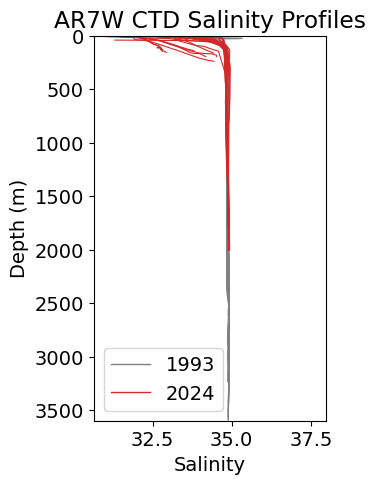

In [55]:
wod_ctd_dir = '/Users/mzahn/data/Labrador_AR7W/WOD_2024/ocldb1770245762.3504832.CTD'
file_list = glob.glob(f'{wod_ctd_dir}/*.nc')

# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []

# configure plot for profiles
fig, ax = plt.subplots(figsize=(3, 5))
# add 1993 profiles
ds_select.ctd_salinity.plot(y='pressure',hue='N_PROF',color='gray',linewidth=0.8,ax=ax,add_legend=False)

# Loop over casts in dataset
for i in range(len(wod_ar7w_2024.time)):
    wod_id = wod_ar7w_2024.isel(time=i).cast.values
    # print(f"Processing cast: {wod_id}")

    # find the corresponding file
    matched_files = [f for f in file_list if str(wod_id) in os.path.basename(f)]
    if not matched_files:
        print(f"No file found for cast {wod_id}")
        continue

    ctd_file = matched_files[0]
    ds = xr.open_dataset(ctd_file)

    # Extract vars
    z = ds['z'].values*-1
    T = ds['Temperature'].where(ds.Temperature_WODflag==0).values
    S = ds['Salinity'].where(ds.Salinity_WODflag==0).values 
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Convert
    P = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)
    
    # Calculate dynamic height referenced to the bottom
    P_ref = P[-1] # bottom depth
    # P_ref = 2000 # bottom depth
    print(P_ref)
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)

    # plot profile
    ds.Salinity.where(ds.Salinity_WODflag==0).plot(y='z',ax=ax,color='tab:red',linewidth=0.8,add_legend=False)

# plot params
# ax.set_xlim(1, 6)
ax.set_ylim(3600, 0)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (m)")
ax.set_title("AR7W CTD Salinity Profiles")
# add legend
legend_lines = [Line2D([0], [0], color='gray', lw=1, label='1993'),
                Line2D([0], [0], color='tab:red', lw=1, label='2024')]

ax.legend(handles=legend_lines,loc='lower left',frameon=True)
plt.show()

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

In [119]:
# convert to meters by dividing by gravity
dyn_height_2024 = dynH_da / 9.81

In [70]:
print(dyn_height_1993.values)
print(dyn_height_2024.values)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.82960175 0.8229917  0.86009154
 0.87138939 0.87239386 0.81579904 0.78542906 0.78849315 0.80466331
 0.80407747 0.80204853 0.8076584  0.82709918 0.80902877 0.81966848
 0.80690958 0.81099653 0.85296283]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.9361205  0.95249601 0.91322686
 0.90712055 0.90712055 0.89456068        nan 0.90561245 0.99372927
 0.94591408 1.01843141 0.93389079 1.01053905 0.99837983 0.98126464
 0.9811135  1.02234435 1.04703309]


### Plot dynamic height across transect

In [137]:
from pyproj import Geod

g = Geod(ellps="WGS84")

lat = dyn_height_2024["lat"]
lon = dyn_height_2024["lon"]
dim = lat.dims[0]

distances = [0.0]  # first point = 0

# Compute distances between consecutive profiles
segment_distances = []
for i in range(len(lat) - 1):
    _, _, d = g.inv(lon[i].item(), lat[i].item(), lon[i+1].item(), lat[i+1].item())
    segment_distances.append(d / 1000.0)  # convert m → km

# Cumulative distance with first profile at 0 km
distance_array = np.insert(np.cumsum(segment_distances), 0, 0.0)

# Add as a new coordinate
dyn_height_2024 = dyn_height_2024.assign_coords(
    distance_along_transect=xr.DataArray(
        distance_array,
        dims=[dim],
        coords={dim: lat[dim]},
        attrs={
            "units": "km",
            "description": "Cumulative distance along transect"}))

In [139]:
dyn_height_1993.values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.82960175,
       0.8229917 , 0.86009154, 0.87138939, 0.87239386, 0.81579904,
       0.78542906, 0.78849315, 0.80466331, 0.80407747, 0.80204853,
       0.8076584 , 0.82709918, 0.80902877, 0.81966848, 0.80690958,
       0.81099653, 0.85296283])

In [141]:
dyn_height_2024.values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.9361205 ,
       0.95249601, 0.91322686, 0.90712055, 0.90712055, 0.89456068,
              nan, 0.90561245, 0.99372927, 0.94591408, 1.01843141,
       0.93389079, 1.01053905, 0.99837983, 0.98126464, 0.9811135 ,
       1.02234435, 1.04703309])

In [143]:
dyn_height_2024.lat.values

array([53.77  , 53.68  , 53.796 , 53.9883, 54.222 , 54.4942, 54.7702,
       54.9512, 55.1128, 55.2628, 55.4198, 55.6123, 55.8447, 55.8447,
       56.1117, 56.538 , 56.9528, 57.3782, 57.802 , 58.2187, 58.638 ,
       59.067 , 59.4825, 59.7507, 59.9868, 60.1717, 60.2908],
      dtype=float32)

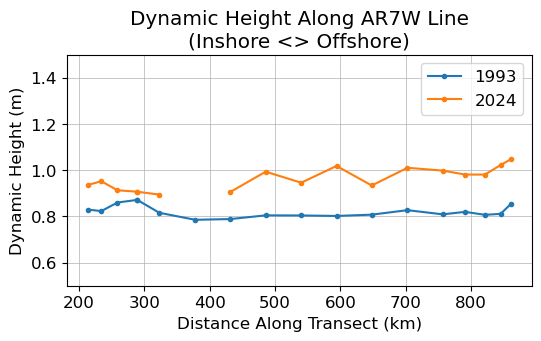

In [145]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[6,3])

plt.plot(dyn_height_2024.distance_along_transect, dyn_height_1993.values, marker='.', label='1993')
plt.plot(dyn_height_2024.distance_along_transect, dyn_height_2024.values, marker='.', label='2024')
plt.grid(linewidth=0.5)

plt.ylim(0.5,1.5)

plt.ylabel('Dynamic Height (m)')
plt.xlabel('Distance Along Transect (km)')
plt.title('Dynamic Height Along AR7W Line\n(Inshore <> Offshore)')

plt.legend();

# Plot difference

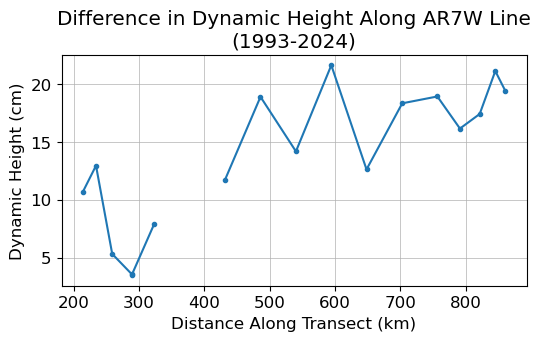

In [148]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[6,3])

plt.plot(dyn_height_2024.distance_along_transect, (dyn_height_2024.values - dyn_height_1993.values)*100, marker='.')
plt.grid(linewidth=0.5)

# plt.ylim(0.5,1.5)

plt.ylabel('Dynamic Height (cm)')
plt.xlabel('Distance Along Transect (km)')
plt.title('Difference in Dynamic Height Along AR7W Line\n(1993-2024)');

# plt.legend();

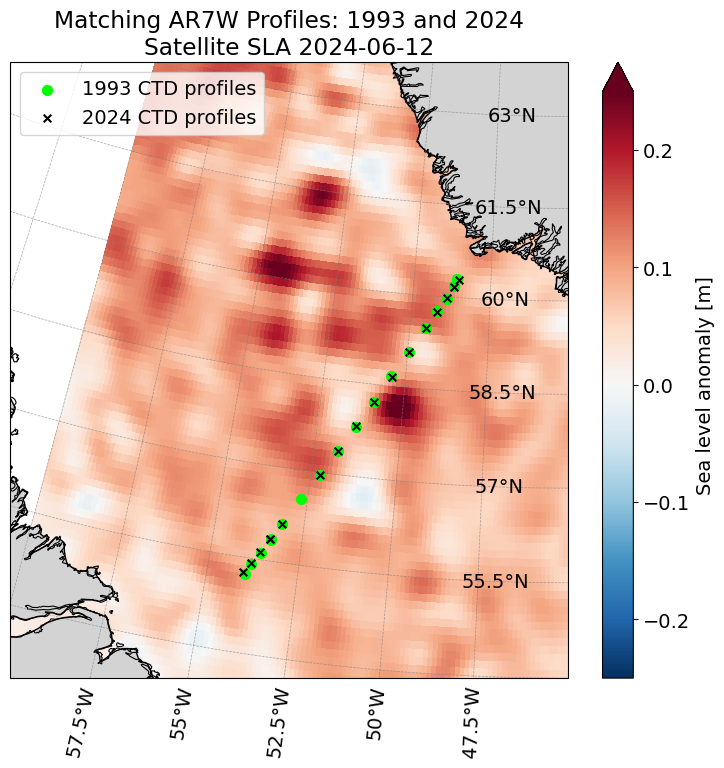

In [150]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
# ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())
# ax.set_extent([-65, -45, 50, 65], crs=ccrs.PlateCarree())
ax.set_extent([-60, -45, 54, 63], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
dyn_height_1993_valid = dyn_height_1993.where(~dyn_height_1993.isnull(), drop=True)
ax.scatter(
    dyn_height_1993_valid.lon.values,
    dyn_height_1993_valid.lat.values,
    s=50,
    color="lime", marker='o',
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles')

# Plot points for 2024
dyn_height_2024_valid = dyn_height_2024.where(~dyn_height_2024.isnull(), drop=True)
ax.scatter(
    dyn_height_2024_valid.lon.values,
    dyn_height_2024_valid.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()

## Collocate CTD profiles with SLA measurement

Interpolate to closest CTD location

In [168]:
sla_interp_list = []

# loop through all CTD profiles and interpolate to exact coordinate
for i in range(len(dyn_height_1993.cast)):
    prof = dyn_height_1993.isel(cast=i)
    date = np.datetime64(prof.time.values, 'D').astype(str)

    sla_val = (ssh_1993.sla.sel(time=date).interp(latitude=prof.lat, 
                                                  longitude=prof.lon).values)

    sla_interp_list.append(sla_val)

# make final dataarray with all interpolated sla vals
sla_ctd_1993 = xr.DataArray(
    np.array(sla_interp_list),
    dims="cast",
    coords={
        "latitude": ("cast", dyn_height_1993.lat.values),
        "longitude": ("cast", dyn_height_1993.lon.values),
    },
    name="sla_interp",
    attrs={"units": "m"})

In [170]:
sla_interp_list = []

# loop through all CTD profiles and interpolate to exact coordinate
for i in range(len(dyn_height_2024.cast)):
    prof = dyn_height_2024.isel(cast=i)
    date = np.datetime64(prof.time.values, 'D').astype(str)

    sla_val = (ssh_2024.sla.sel(time=date).interp(latitude=prof.lat, 
                                                  longitude=prof.lon).values)

    sla_interp_list.append(sla_val)

# make final dataarray with all interpolated sla vals
sla_ctd_2024 = xr.DataArray(
    np.array(sla_interp_list),
    dims="cast",
    coords={
        "latitude": ("cast", dyn_height_2024.lat.values),
        "longitude": ("cast", dyn_height_2024.lon.values),
    },
    name="sla_interp",
    attrs={"units": "m"})

In [172]:
sla_ctd_diff_cm = (sla_ctd_2024 - sla_ctd_1993)*100

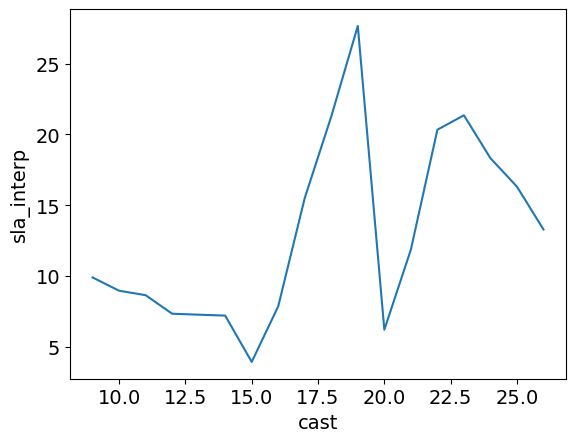

In [178]:
sla_ctd_diff_cm.where(~dyn_height_1993.isnull()).plot()

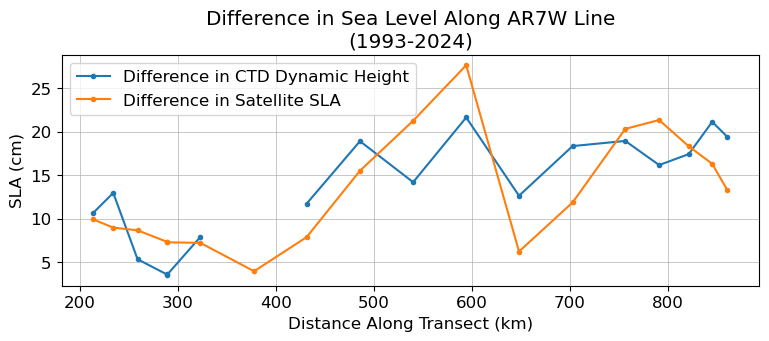

In [200]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[9,3])

plt.plot(dyn_height_2024.distance_along_transect,\
         (dyn_height_2024.values - dyn_height_1993.values)*100, marker='.',label='Difference in CTD Dynamic Height')
plt.grid(linewidth=0.5)

plt.plot(dyn_height_2024.distance_along_transect,\
         sla_ctd_diff_cm.where(~dyn_height_1993.isnull()), marker='.', label='Difference in Satellite SLA')

# plt.ylim(0.5,1.5)

plt.ylabel('SLA (cm)')
plt.xlabel('Distance Along Transect (km)')
plt.title('Difference in Sea Level Along AR7W Line\n(1993-2024)');

plt.legend();